In [1]:
import diffusion as diffusion_lib
import diffusion.beta_schedule as schedule_lib
import samplers as sampler_lib
import training.time_sampler as time_sampler_lib
import datasets as dataset_lib
import training.losses as loss_lib
import training.train as train_lib
import utils.config as config_lib
import models.mlp as model_lib
import utils.logging as loglib

import flax
import jax
import jax.numpy as jnp
import optax
import functools
import copy

import matplotlib.pyplot as plt
import numpy as np
import einops
import time

In [2]:
# input parameters
# --------------------------------------------
# training
batch_size = 128
seed = 42
rng = jax.random.PRNGKey(seed)
num_training_iterations = 100_000
ema_rate = 0.99
num_devices = jax.local_device_count()

# optimizer
optimizer_config = config_lib.Config(learning_rate=2e-4) #, b1=0.9, b2=0.999, eps=1e-8)
scheduler_config = config_lib.Config(init_value=1.0, decay_steps=1_000, alpha=0.0)

# dataset
# dataset_name = "CIFAR10"
# image_size = 32
# data_shape = (image_size, image_size, 3)
dataset_name = dataset_lib.MOON
data_shape = (2,)

# diffusion
T_max = 1.0
t_0 = 1e-4
num_timesteps = 1000

beta_max = 10.0
beta_min = 0.01

mean_T = jnp.zeros(data_shape)
sigma_T = 4*jnp.ones(data_shape)

In [3]:
# Set up
# --------------------------------------------
# --------------------------------------------

# data
# --------------------------------------------
train_ds, eval_ds = dataset_lib.get_dataset(
    dataset_name,
    train_batch_size=batch_size,
    eval_batch_size=batch_size,
    num_jit_steps=None,
    image_size=None,
    random_flip=None,
    data_category=None,
    uniform_dequantization=False,
    num_two_dim_samples=10_000,
)
train_iter = iter(train_ds)

# set up data transform
transform_fn = lambda x: x

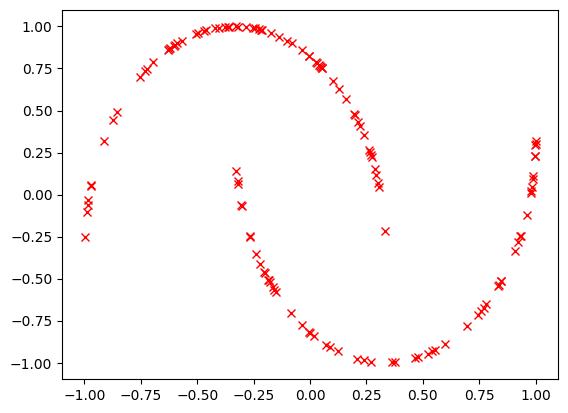

In [7]:
batch = jax.tree_map(lambda x: x._numpy(), next(train_iter))
x = batch['x']
plot_x = x[0]
plt.plot(plot_x[:,0], plot_x[:,1], 'rx')

In [8]:
# forward diffusion
# --------------------------------------------
beta_schedule = schedule_lib.LinearSchedule(
    beta_0=beta_min, beta_T=beta_max, t_0=0, T=T_max
)
state_sampler = sampler_lib.get_ornstein_uhlenbeck_sampler(
    mean_T=mean_T, sigma_T=sigma_T, beta_schedule=beta_schedule
)
drift_fn, diffusion_scale_fn = diffusion_lib.get_ornstein_uhlenbeck_diffusion(
    mean_T=mean_T, sigma_T=sigma_T, beta_schedule=beta_schedule
)

# set up time sampler
time_sampler = functools.partial(
    time_sampler_lib.uniform_time_sampler, t_0=t_0, T=T_max
)
noising_fn = sampler_lib.get_noising_fn(time_sampler, state_sampler)

In [9]:
beta_schedule.integral_beta_t(T_max), T_max

(5.005, 1.0)

(Array([-0.3625722 ,  0.06977099], dtype=float32),
 Array([3.4748652, 3.5723996], dtype=float32))

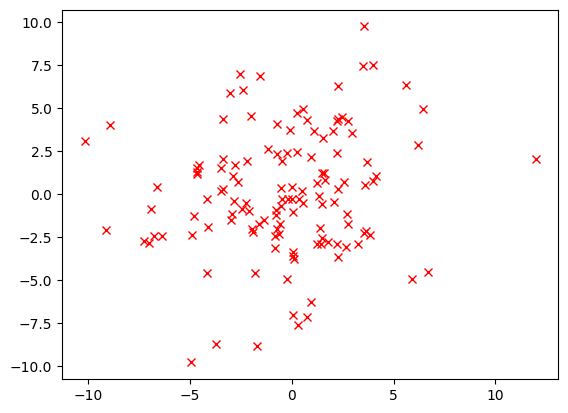

In [10]:
init_t = jnp.zeros((batch_size,))
init_x = x[0]
init_rng = jax.random.PRNGKey(0)

init_state = diffusion_lib.init_diffusion_state(
        x_init=init_x, t_init=init_t, rng=init_rng
    )
t = jnp.ones((batch_size))*T_max
forward_state = state_sampler(init_state, t)
plot_x = forward_state.x_t
plt.plot(plot_x[:,0], plot_x[:,1], 'rx')
plot_x.mean(0), plot_x.std(0)

In [12]:
# model
# --------------------------------------------
model = model_lib.MLPDiffusionModel()

# training
# --------------------------------------------
# set up optimizer
schedule_fn = optax.cosine_decay_schedule(**scheduler_config.as_dict())
optimizer = optax.chain(
    optax.adam(**optimizer_config.as_dict())
#     , optax.scale_by_schedule(schedule_fn)
)


def weight_fn(forward_state):
    int_t =  beta_schedule.integral_beta_t(forward_state.t)-beta_schedule.integral_beta_t(t_0)
    _, std = sampler_lib.compute_ou_moments(mean_T, sigma_T, forward_state.x_0, int_t)
    return 1 / (1e-3+std[:,0])

# setup training step
loss_fn = loss_lib.get_matching_loss_fn(
    model=model,
    weight_fn=weight_fn
)
train_step = train_lib.get_train_step_fn(
    loss_fn=loss_fn,
    optimizer=optimizer,
    ema_rate=ema_rate,
    noising_fn=noising_fn,
)

In [10]:
# def weight_fn(t):
#     _, std = sampler_lib.compute_ou_moments(mean_T, sigma_T, jnp.ones((t.shape[0], *mean_T.shape)), 
#                                             t=beta_schedule.integral_beta_t(T_max - t))
#     return 1 / std[:,0]

# rng, step_rng = jax.random.split(rng)
# t = time_sampler(step_rng, (128,))
# jnp.sum(weight_fn(t)), jnp.where(weight_fn(t)==weight_fn(t).max())

In [13]:
# init training state
# --------------------------------------------
dummy_x = jnp.ones((1, *data_shape))
dummy_t = jnp.ones((1,))
rng, init_rng = jax.random.split(rng)

model_vars = model.init(rng, dummy_x, dummy_t)
model_state, params = model_vars.pop("params")
opt_state = optimizer.init(params)


# setup train state
train_state = train_lib.TrainState(
    step=0,
    params=params,
    model_state=model_state,
    opt_state=opt_state,
    ema_params=copy.deepcopy(params),
)

In [14]:
p_train_step = jax.pmap(train_step, axis_name="batch", donate_argnums=1)
pstate = flax.jax_utils.replicate(train_state)

In [15]:
# training loop
# --------------------------------------------
start_time = time.time()
losses = []
for it in range(num_training_iterations):
    rng, train_rng, time_rng, init_rng = jax.random.split(rng, 4)
    batch = jax.tree_map(lambda x: x._numpy(), next(train_iter))
    x = batch["x"]
    z = transform_fn(x)

    init_t = jnp.zeros((num_devices, batch_size))
    init_rng = jax.random.split(init_rng, num_devices)
    init_state = diffusion_lib.init_diffusion_state(
        x_init=z, t_init=init_t, rng=init_rng
    )

    # rng per device
    train_rng = jnp.asarray(jax.random.split(train_rng, num_devices))

    # train step
    carry_state = (train_rng, pstate)
    (_, pstate), (loss, step) = p_train_step(
        carry_state,
        init_state,
    )
    
    
    # metrics
    if it % 500 == 0:
        losses.append(loss.item())
        runtime = time.time() - start_time
        train_state = flax.jax_utils.unreplicate(pstate)
        print_metrics = {"step": step, "loss": loss, "runtime": runtime}
        loglib.print_metrics(print_metrics)

step: 1 - loss: 5.964327 - runtime: 2.801416
step: 501 - loss: 0.607335 - runtime: 6.313570
step: 1001 - loss: 0.649291 - runtime: 9.661267
step: 1501 - loss: 0.605345 - runtime: 13.050084
step: 2001 - loss: 1.233570 - runtime: 16.442043
step: 2501 - loss: 3.000475 - runtime: 20.288064
step: 3001 - loss: 1.061845 - runtime: 23.492572
step: 3501 - loss: 0.926890 - runtime: 26.509379
step: 4001 - loss: 1.094918 - runtime: 29.774025
step: 4501 - loss: 0.473966 - runtime: 32.891677
step: 5001 - loss: 0.621168 - runtime: 36.539301
step: 5501 - loss: 1.586321 - runtime: 40.138681
step: 6001 - loss: 0.817743 - runtime: 43.358093
step: 6501 - loss: 0.651640 - runtime: 47.404556
step: 7001 - loss: 2.213947 - runtime: 50.918848
step: 7501 - loss: 0.625826 - runtime: 54.560329
step: 8001 - loss: 0.635616 - runtime: 57.998833
step: 8501 - loss: 0.891447 - runtime: 61.365043
step: 9001 - loss: 0.202585 - runtime: 64.643087
step: 9501 - loss: 0.895044 - runtime: 68.025379
step: 10001 - loss: 0.76128

step: 81001 - loss: 0.474008 - runtime: 529.631576
step: 81501 - loss: 1.004862 - runtime: 532.831153
step: 82001 - loss: 0.306527 - runtime: 536.095197
step: 82501 - loss: 1.987841 - runtime: 539.130488
step: 83001 - loss: 0.789349 - runtime: 542.162914
step: 83501 - loss: 6.293885 - runtime: 545.195589
step: 84001 - loss: 0.316275 - runtime: 548.329592
step: 84501 - loss: 0.328052 - runtime: 551.482011
step: 85001 - loss: 5.608029 - runtime: 554.489723
step: 85501 - loss: 0.543175 - runtime: 557.548848
step: 86001 - loss: 0.336216 - runtime: 560.713007
step: 86501 - loss: 0.746885 - runtime: 563.930135
step: 87001 - loss: 0.659240 - runtime: 567.161518
step: 87501 - loss: 0.321883 - runtime: 570.476596
step: 88001 - loss: 2.273825 - runtime: 573.824468
step: 88501 - loss: 0.269356 - runtime: 577.064562
step: 89001 - loss: 0.388378 - runtime: 580.270382
step: 89501 - loss: 1.921398 - runtime: 583.468075
step: 90001 - loss: 1.556282 - runtime: 586.503085
step: 90501 - loss: 0.296717 - 

In [16]:
import models.model_utils as mutils
import diffusion.transforms as transforms
from samplers import euler_maruyama
import utils.math as ops

In [17]:
rev_score_fn = mutils.get_model_fn(
    model,
    train_state.ema_params,
    train_state.model_state,
    train=False,
)


rng = jax.random.PRNGKey(0)
rng, rng_step = jax.random.split(rng)
batch_size = 512
x_init = jax.random.normal(rng, (batch_size, *data_shape))
t_init = jnp.zeros((batch_size,))


init_diffusion_state = diffusion_lib.init_diffusion_state(
    x_init=x_init, t_init =t_init, rng=rng
)


def weight_fn(t):
    _, std = sampler_lib.compute_ou_moments(mean_T, sigma_T, jnp.ones((t.shape[0], *mean_T.shape)), 
                                            t=beta_schedule.integral_beta_t(T_max - t))
    return 1 / std[:,0]

def score_fn(x,t):
    
    score_fn = transforms.reverse_time_argument(rev_score_fn, argnum=1, T_max=T_max)
    return ops.batch_mul(score_fn(x,t), weight_fn(t))



backward_drift_fn, backward_scale_fn = transforms.time_reversal(forward_drift_fn=drift_fn, 
                         forward_diffusion_scale_fn=diffusion_scale_fn, 
                         reverse_score_fn=score_fn, T_max=T_max)

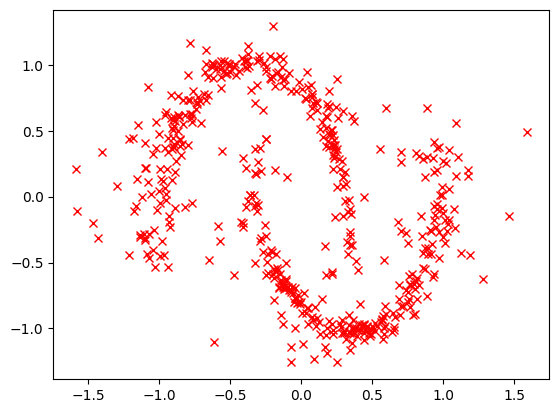

In [18]:

n_steps = 1000
step_schedule = T_max*jnp.ones(n_steps) / n_steps

diffusion_state = euler_maruyama(
    diffusion_state=init_diffusion_state,
    step_schedule=step_schedule,
    drift_fn=backward_drift_fn,
    diffusion_scale_fn=backward_scale_fn,
    return_trajectory=False
)
plot_x = diffusion_state['x_t']
plt.plot(plot_x[:,0], plot_x[:,1], 'rx')

In [19]:
diffusion_state = euler_maruyama(
    diffusion_state=init_diffusion_state,
    step_schedule=step_schedule,
    drift_fn=backward_drift_fn,
    diffusion_scale_fn=backward_scale_fn,
    return_trajectory=True
)
plot_x = diffusion_state['mean_t']

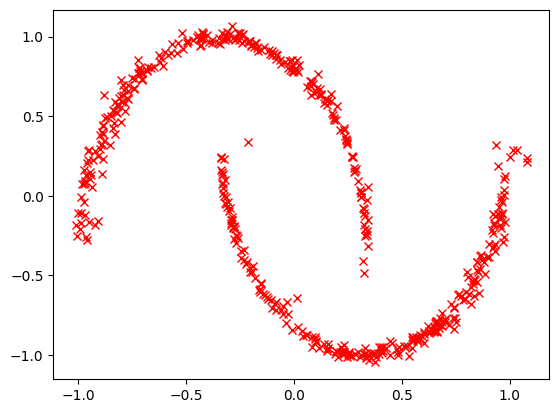

In [38]:
plt.plot(plot_x[-1, :,0], plot_x[-1, :,1], 'rx')

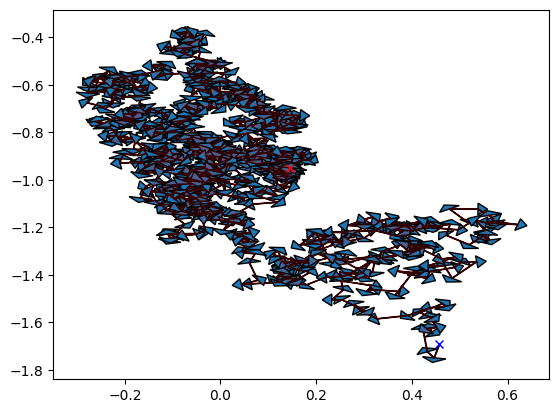

In [25]:
plt.plot(plot_x[:, 0,0], plot_x[:, 0,1], 'r', alpha=0.2)
x, y = plot_x[0, 0,0], plot_x[0, 0,1]
for next_x, next_y in zip(plot_x[1:, 0,0], plot_x[1:, 0,1]):
    dx, dy = next_x-x, next_y - y
    plt.arrow(x, y, dx, dy, head_width=0.05, head_length=0.02)
    x, y = next_x, next_y
    
plt.plot(plot_x[-1, 0,0], plot_x[-1, 0,1], 'rx')
plt.plot(plot_x[0, 0,0], plot_x[0, 0,1], 'bx')

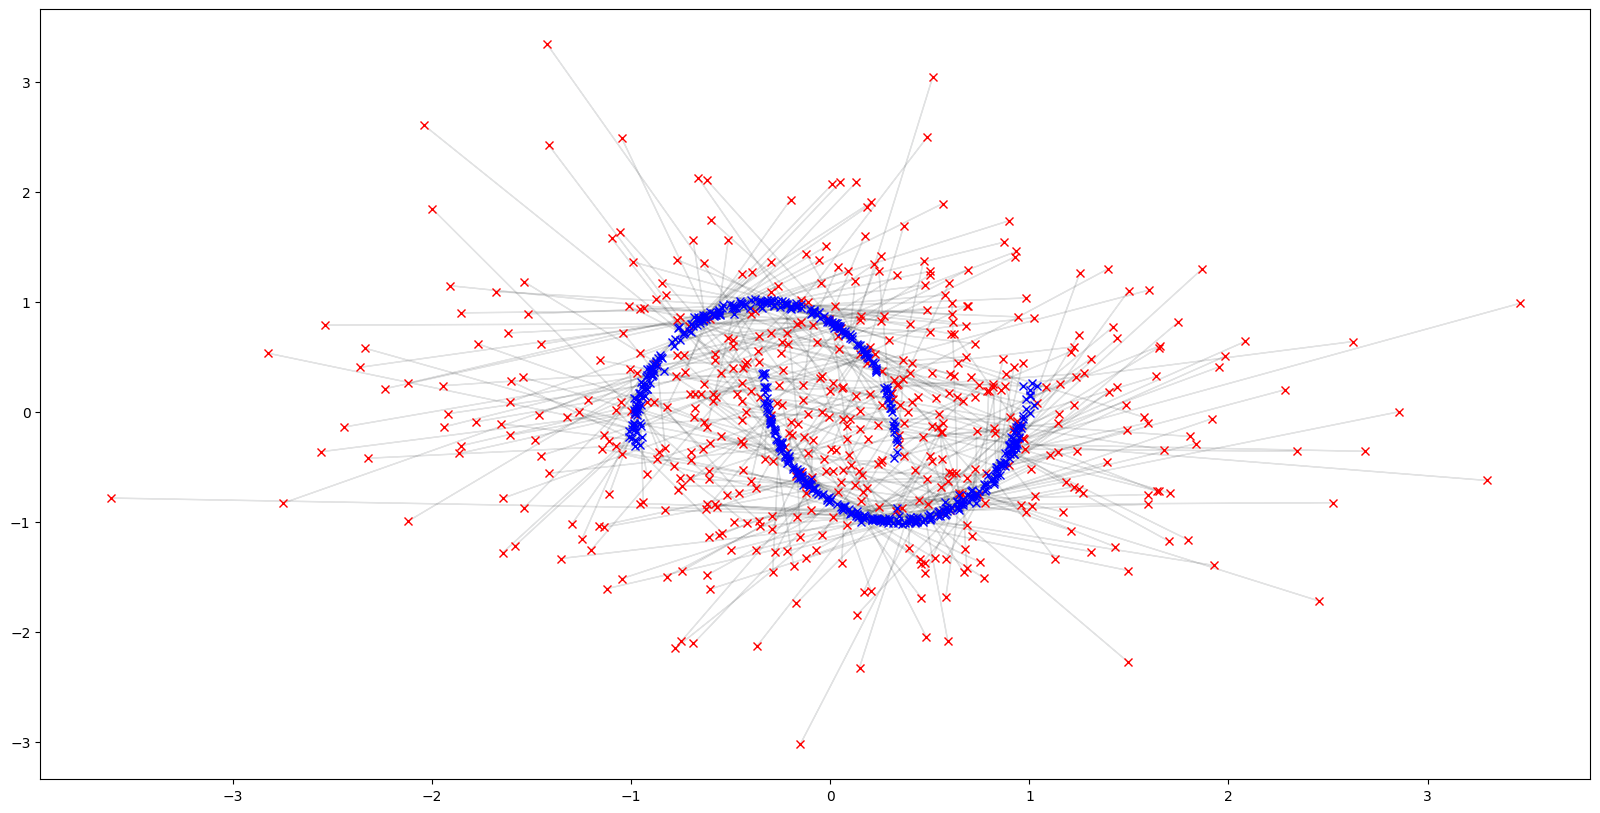

In [26]:
plt.figure(figsize=(20,10))
x_0, y_0 = plot_x[0, :,0], plot_x[0, :,1]
x_T, y_T = plot_x[-1, :,0], plot_x[-1, :,1]
dx, dy = x_T - x_0, y_T - y_0

plt.plot(x_0, y_0, 'rx')
plt.plot(x_T, y_T, 'bx')

for item in zip(x_0, y_0, dx, dy):
    plt.arrow(*item, head_width=0.05, head_length=0.02, alpha=0.1)

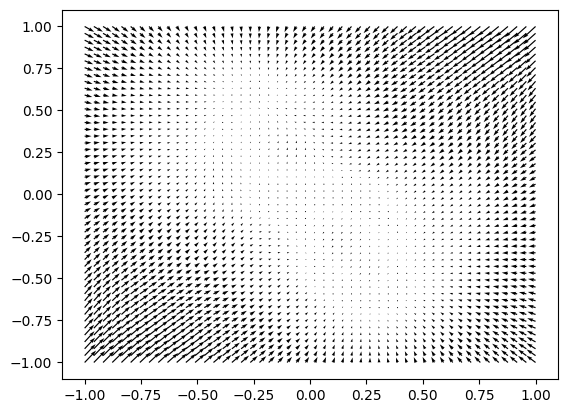

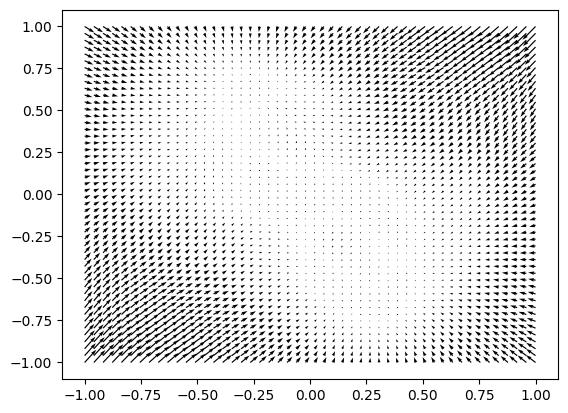

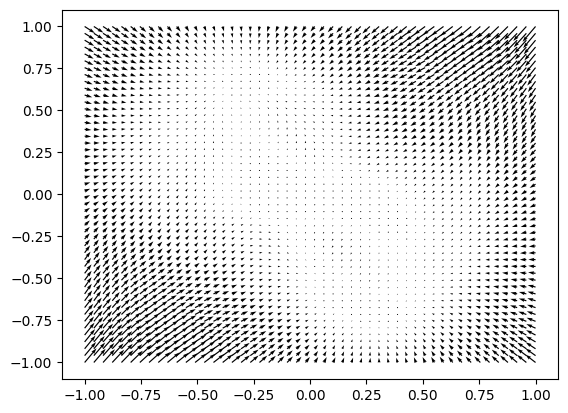

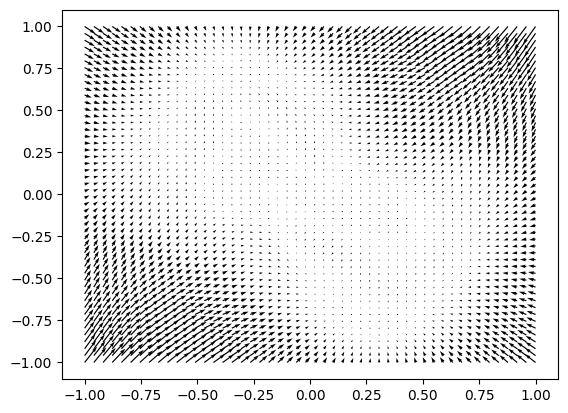

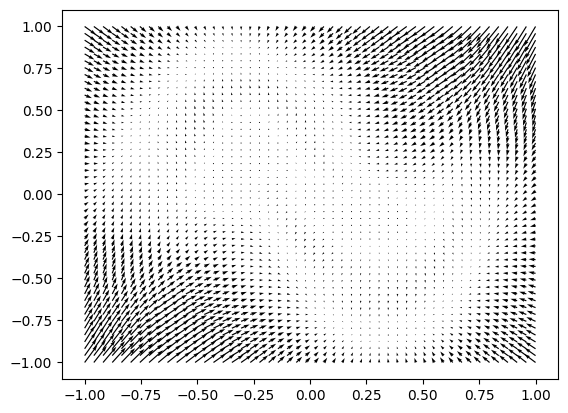

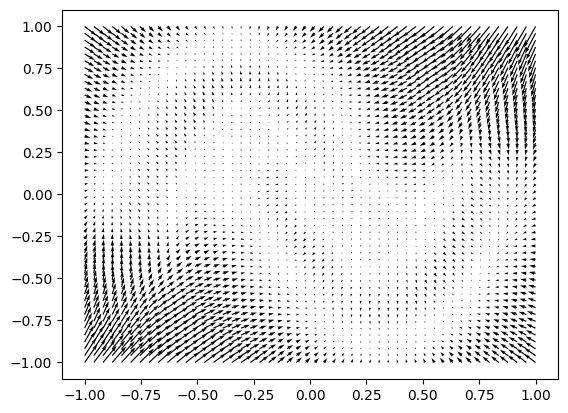

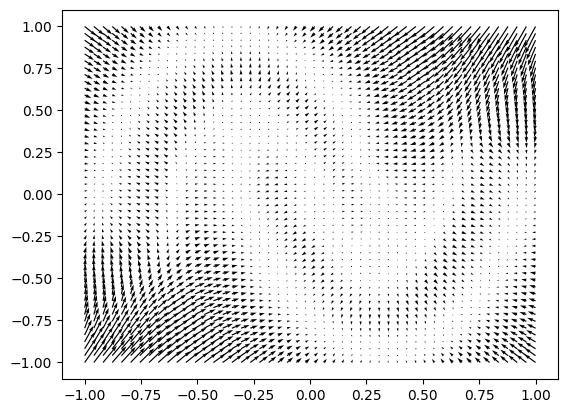

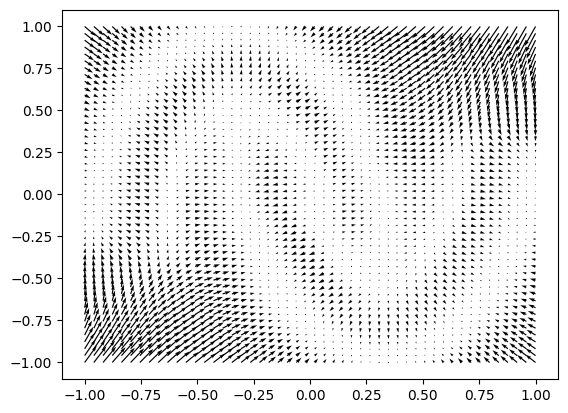

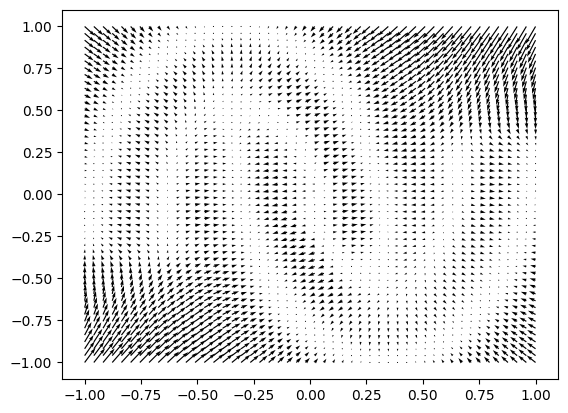

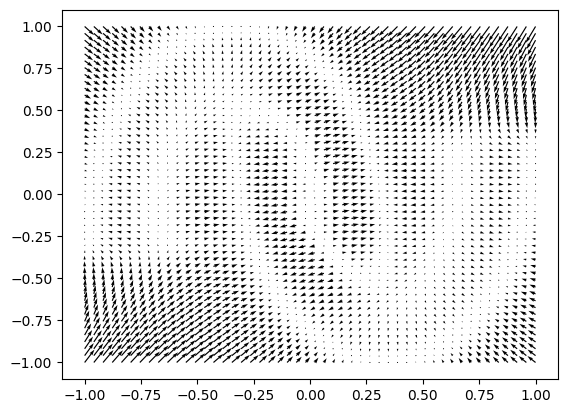

In [27]:
grid_w = 1
res = 50
x,y = jnp.meshgrid(np.linspace(-grid_w,grid_w,res),np.linspace(-grid_w,grid_w,res))
x.shape, y.shape
flat_x = einops.rearrange(x, 'a b -> (a b)')
flat_y = einops.rearrange(y, 'a b -> (a b)')
network_input = jnp.stack([flat_x, flat_y], -1)
    
for t in jnp.arange(t_0, T_max, T_max/10):

    t = jnp.ones(network_input.shape[0])*t
    score = score_fn(x=network_input, t=t)
    dx, dy = jnp.split(score, 2, axis=-1)
    plt.quiver(flat_x, flat_y,dx,dy)
    plt.show()